![Fixel Algorithms](https://fixelalgorithms.co/images/CCExt.png)

# <center> Deep Learning Methods </center>
## <center> Lecture 6 - Convolutional Neural Network</center>
### <center> 1D CNN </center>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/FixelAlgorithmsTeam/FixelCourses/blob/master/DeepLearningMethods/06_CNN/MainCnn1D.ipynb)

In [1]:
#-- Wide screen:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
#-- Auto reload:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib
import torch

matplotlib.rc('font', **{'size' : 16})

For Colab users:

In [4]:
if 'google.colab' in str(get_ipython()):
    !npx degit FixelAlgorithmsTeam/FixelCourses/DeepLearningMethods/06_CNN/DeepLearningFramework ./DeepLearningFramework

In [5]:
from DeepLearningFramework.Training import TrainRegressionModel

### Generate some data (for frequency estimation):
$$\boldsymbol{x}_{i}\left(t\right)=\sin\left(2\pi f_{i}t+\phi_{i}\right)+n_{i}\left(t\right)$$
**Input**: The signal $x_i(t)$  
**Output**.: The signal frequency $f_i$  

Recall that `torch.tensor` is very similar to `numpy.ndarray`

In [6]:
nTrain = 10000 #-- number of training points
Fs     = 100   #-- sample frequency
T      = 5     #-- observation time (sec)
σ      = 0.1
π      = np.pi

t    = torch.linspace(0, T, T * Fs) #-- time axis
vF   = 10 * torch.rand(nTrain)      #-- frequencies
vPhi = 2  * π * torch.rand(nTrain)  #-- random phase

#-- Generate signals: x_i(t) = sin(2π f_i t + φ_i) + n_i(t)
mX = torch.sin(2 * π * vF[:,None] @ t[None,:] + vPhi[:,None])
mX = mX + σ * torch.randn(mX.shape) #-- add noise

mX.shape, mX.size() #-- in PyTorch, we have both shape and size().

(torch.Size([10000, 500]), torch.Size([10000, 500]))

### Plot some examples:

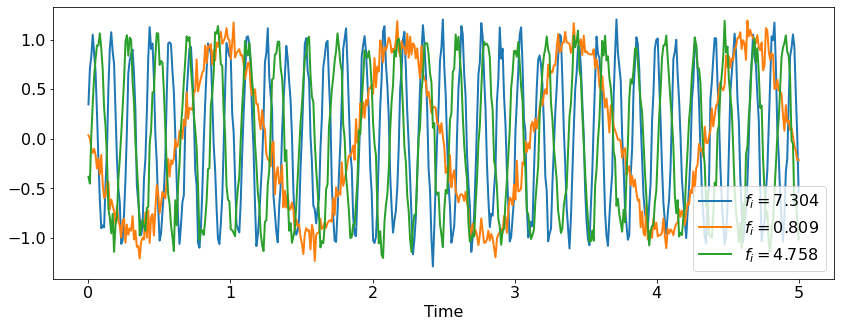

In [7]:
plt.figure(figsize=(14,5))
plt.xlabel('Time')
for _ in range(3):
    idx = np.random.randint(nTrain)
    vX  = mX[idx,:]
    plt.plot(t, vX, lw=2, label=f'$f_i = {(vF[idx].item()):.3f}$')

plt.legend()
plt.show  ()

### Input data: (N x Channels X Length)
The input to 1D CNN is `NxCxL` so we use `view` to add a new axis (`unsqueeze` will work as well).

In [8]:
mX = mX.view(nTrain, 1, -1) #-- N x Channels x Length
mX.shape 

torch.Size([10000, 1, 500])

#### Split data to train and validation:

In [9]:
oDataSet            = torch.utils.data.TensorDataset(mX, vF)
oTrainSet, oValSet  = torch.utils.data.random_split(oDataSet, np.round([0.9 * nTrain, 0.1 * nTrain]).astype(int))
len(oTrainSet), len(oValSet)

(9000, 1000)

#### Create data loaders:

In [10]:
batchSize = 512
oTrainDL  = torch.utils.data.DataLoader(oTrainSet, shuffle=True,  batch_size=batchSize)
oValDL    = torch.utils.data.DataLoader(oValSet,   shuffle=False, batch_size=2*batchSize)

#### Define the model (1D CNN):

In [11]:
import torch.nn            as nn
import torch.nn.functional as F
import torch.optim         as optim
import torchsummary

from DeepLearningFramework.Layers import Squeeze

#-- Model:
def GetModel():
    oModel = nn.Sequential(
        nn.Identity(), #-- does nothing
        
        nn.Conv1d(in_channels=1,   out_channels=50,  kernel_size=11), nn.MaxPool1d(kernel_size=2), nn.ReLU(),
        nn.Conv1d(in_channels=50,  out_channels=100, kernel_size=11), nn.MaxPool1d(kernel_size=2), nn.ReLU(),
        nn.Conv1d(in_channels=100, out_channels=200, kernel_size=11), nn.MaxPool1d(kernel_size=2), nn.ReLU(),
        nn.Conv1d(in_channels=200, out_channels=300, kernel_size=11), nn.MaxPool1d(kernel_size=2), nn.ReLU(),
                
        nn.AdaptiveAvgPool1d(output_size=1),
        nn.Flatten(),
        nn.Linear(in_features=300, out_features=1),
        Squeeze(),
    )
    
    return oModel

#-- Model summary:
torchsummary.summary(GetModel(), mX[0,:,:].shape, device='cpu');

Layer (type:depth-idx)                   Output Shape              Param #
├─Identity: 1-1                          [-1, 1, 500]              --
├─Conv1d: 1-2                            [-1, 50, 490]             600
├─MaxPool1d: 1-3                         [-1, 50, 245]             --
├─ReLU: 1-4                              [-1, 50, 245]             --
├─Conv1d: 1-5                            [-1, 100, 235]            55,100
├─MaxPool1d: 1-6                         [-1, 100, 117]            --
├─ReLU: 1-7                              [-1, 100, 117]            --
├─Conv1d: 1-8                            [-1, 200, 107]            220,200
├─MaxPool1d: 1-9                         [-1, 200, 53]             --
├─ReLU: 1-10                             [-1, 200, 53]             --
├─Conv1d: 1-11                           [-1, 300, 43]             660,300
├─MaxPool1d: 1-12                        [-1, 300, 21]             --
├─ReLU: 1-13                             [-1, 300, 21]             --


### Check whether GPU is available:

In [12]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
DEVICE

device(type='cuda')

In [13]:
oModel  = GetModel().to(DEVICE)
oOptim  = optim.Adam(oModel.parameters(), lr=1e-4, betas=(0.9, 0.99))
Loss    = nn.MSELoss()
nEpochs = 30

TrainRegressionModel(oModel, oTrainDL, oValDL, Loss, nEpochs, oOptim);

Epoch 000: | Train loss: 21.61095 | Val loss: 4.08935 | Train R2: -1.5684 | Val R2: +0.5022 | epoch time: 2.567 | <-- Checkpoint!
Epoch 001: | Train loss: 4.25949 | Val loss: 2.48034 | Train R2: +0.4946 | Val R2: +0.6981 | epoch time: 1.678 | <-- Checkpoint!
Epoch 002: | Train loss: 1.30760 | Val loss: 0.58872 | Train R2: +0.8441 | Val R2: +0.9283 | epoch time: 1.637 | <-- Checkpoint!
Epoch 003: | Train loss: 0.40227 | Val loss: 0.24388 | Train R2: +0.9523 | Val R2: +0.9703 | epoch time: 1.636 | <-- Checkpoint!
Epoch 004: | Train loss: 0.20497 | Val loss: 0.14189 | Train R2: +0.9757 | Val R2: +0.9827 | epoch time: 1.641 | <-- Checkpoint!
Epoch 005: | Train loss: 0.11635 | Val loss: 0.08277 | Train R2: +0.9862 | Val R2: +0.9899 | epoch time: 1.640 | <-- Checkpoint!
Epoch 006: | Train loss: 0.07197 | Val loss: 0.05224 | Train R2: +0.9914 | Val R2: +0.9936 | epoch time: 1.640 | <-- Checkpoint!
Epoch 007: | Train loss: 0.04772 | Val loss: 0.03484 | Train R2: +0.9943 | Val R2: +0.9958 | epo

### Test the model:

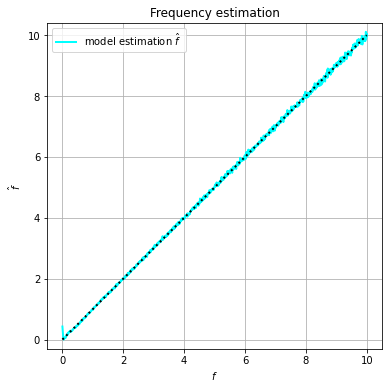

In [14]:
nTest  = 1001

#-- Generate test data:
vTestF = torch.linspace(0, 10, nTest)
mTestX = torch.sin(2 * π * vTestF[:,None] @ t[None,:])
mTestX = mTestX + σ * torch.randn(mTestX.shape)

#-- Apply model:
with torch.no_grad():
    vHatTestF = oModel(mTestX.view(nTest,1,-1).to(DEVICE)).squeeze()
vHatTestF = vHatTestF.detach().cpu() #-- move to CPU

plt.figure(figsize=(6, 6))
plt.plot  (vTestF, vHatTestF, 'cyan', lw=2, label='model estimation $\hat{f}$')
plt.plot  (vTestF, vTestF,   ':k',    lw=2)
plt.title ('Frequency estimation')
plt.xlabel('$f$')
plt.ylabel('$\hat{f}$')
plt.axis  ('equal')
plt.legend()
plt.grid  ()
plt.show  ()


### Question:
What will happen (and why) if we change (line 6):  
`vTestF = torch.linspace(0, 10, Ntest)`  
into  
`vTestF = torch.linspace(0, 15, Ntest)`  
?